In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

TensorFlow 2.x selected.


In [0]:
import os
import sys
import math
import time
import itertools

import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

# Adversarial attacks

![](https://openai.com/content/images/2017/02/adversarial_img_1.png)

# Fast Gradient Sign Method(FGSM)

FGSM is a single step attack, ie.. the perturbation is added in a single step. 

## Untargetted attack

![](https://cv-tricks.com/wp-content/uploads/2018/05/fgsm.png)

## Targetted attack

![](https://cv-tricks.com/wp-content/uploads/2018/05/target_fgsm.png)

# Iterative methods

Instead of applying the perturbation in a single step, it is applied multiple times with a small step size. In this method, the pixel values of intermediate results are clipped after each step to ensure that they are in an 𝜺 neighbourhood of the original image ie.. within the range $[X_{i,j}−𝜺, X_{i,j}+𝜺]$, $X_{i,j}$ being the pixel value of the previous image.

![](https://cv-tricks.com/wp-content/uploads/2018/05/iterative.png)

# Load CIFAR10 dataset

In [3]:
NUM_CLASSES = 10
cifar = keras.datasets.cifar10

(X_train, y_train), (X_test, y_test) = cifar.load_data()

X_train = X_train / 255
X_test = X_test / 255

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

y_train = keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_train.dtype, y_train.dtype, X_test.dtype, y_test.dtype)

170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)
float32 float32 float32 float32


In [0]:
cifar_classes = np.array([
    'airplane',								
    'automobile', 										
    'bird', 										
    'cat', 										
    'deer', 										
    'dog', 										
    'frog', 										
    'horse', 										
    'ship', 										
    'truck'
])

# Define and train ConvNet for CIFAR classification

You can experiment with various architectures.

In [0]:
x_in = keras.layers.Input(shape=(32,32,3))
x = keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation='relu')(x_in)
x = keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation='relu')(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation='relu')(x)
logits = keras.layers.Dense(10, activation="softmax")(x)

In [0]:
model = keras.models.Model(inputs=[x_in], outputs=[logits])

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=["accuracy"])

In [8]:
model.fit(X_train, y_train, epochs=10, batch_size=128,
          validation_data=(X_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 11s 214us/sample - loss: 1.4828 - accuracy: 0.4622 - val_loss: 1.1505 - val_accuracy: 0.5897
Epoch 2/10
50000/50000 [==============================] - 4s 78us/sample - loss: 1.0476 - accuracy: 0.6304 - val_loss: 0.9645 - val_accuracy: 0.6629
Epoch 3/10
50000/50000 [==============================] - 4s 77us/sample - loss: 0.8506 - accuracy: 0.7033 - val_loss: 0.8381 - val_accuracy: 0.7065
Epoch 4/10
50000/50000 [==============================] - 4s 77us/sample - loss: 0.7225 - accuracy: 0.7495 - val_loss: 0.8883 - val_accuracy: 0.6932
Epoch 5/10
50000/50000 [==============================] - 4s 77us/sample - loss: 0.6227 - accuracy: 0.7824 - val_loss: 0.7660 - val_accuracy: 0.7333
Epoch 6/10
50000/50000 [==============================] - 4s 77us/sample - loss: 0.5435 - accuracy: 0.8113 - val_loss: 0.7323 - val_accuracy: 0.7454
Epoch 7/10
50000/50000 [==============================

# Select image to attack, plot it and see the network classification

In [0]:
def get_classification_report(image, k=3):
    pred_probas = model(image).numpy().flatten()
    pred_labels = np.argsort(pred_probas)[::-1]
    pred_classes = cifar_classes[pred_labels]
    for i in range(k):
        print("Predicted class: %s, with proba: %.3f" % (pred_classes[i], pred_probas[pred_labels[i]]))

True image class: ship


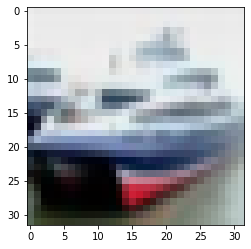

In [10]:
img_ind = 1
test_image = X_test[img_ind:(img_ind+1)].astype(np.float32)
test_image = tf.convert_to_tensor(test_image)
print("True image class: %s" % cifar_classes[np.argmax(y_test[img_ind])])
plt.imshow(test_image[0])

In [11]:
get_classification_report(test_image, k=3)

Predicted class: ship, with proba: 0.816
Predicted class: automobile, with proba: 0.184
Predicted class: airplane, with proba: 0.000


# 1. Untargetted

![](https://cv-tricks.com/wp-content/uploads/2018/05/fgsm.png)

Define the cross entropy loss [keras.losses.CategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy)

In [0]:
cce = keras.losses.CategoricalCrossentropy()

Define the epsilon. You can experiment with different epsilon sizes.

In [0]:
eps = 0.02

**Define the attack**

Get the image, compute its logits predicted by the network, then compute the label of the most probable image (you could use [tf.math.argmax](https://www.tensorflow.org/api_docs/python/tf/math/argmax) function), make the one-hot-encoding vector (you could use [tf.one_hot](https://www.tensorflow.org/api_docs/python/tf/one_hot) function) and calculate the cross-entropy between one-hot-encoding and predicted logits.


We will need to compute the gradient of the cross-entropy loss with respect to the image. We are using the eager execution mode, so that you should remember about defining the [gradient taping](https://www.tensorflow.org/api_docs/python/tf/GradientTape) and watching the *test_image* tensor.

In [0]:
with tf.GradientTape() as g:
    # Watch the test image
    g.watch(test_image)
    # Get the logits predicted by the network
    logits = model(test_image)
    # Get the label of the image predicted by the network 
    label = tf.math.argmax(logits, 1)
    # Make one hot encoding from this label (you could use tf.one_hot function)
    one_hot_label = tf.one_hot(label, NUM_CLASSES)
    # Get the cross-entropy loss between one hot encoding and predicted logits
    image_cross_entropy = cce(one_hot_label, logits)

Calculate the gradient of cross entropy loss with respect to the input image

In [15]:
grad = g.gradient(image_cross_entropy, test_image)
grad

<tf.Tensor: shape=(1, 32, 32, 3), dtype=float32, numpy=
array([[[[-3.72165116e-04,  1.59375556e-02,  3.55788879e-02],
         [-2.62921117e-02, -4.93009388e-02, -1.64584015e-02],
         [-9.54607036e-04,  2.24716682e-02,  3.99576500e-04],
         ...,
         [ 2.77776010e-02,  4.86865640e-03,  2.79853884e-02],
         [-2.53783241e-02, -1.42563172e-02, -4.87651713e-02],
         [-3.30969803e-02, -5.12226894e-02, -4.93628420e-02]],

        [[ 5.73548228e-02,  5.66785373e-02,  2.27993764e-02],
         [ 3.33944932e-02, -7.77306855e-02, -2.20804326e-02],
         [ 6.60298914e-02, -1.62074156e-03, -1.31238578e-03],
         ...,
         [ 1.89894252e-03, -1.48325972e-03, -2.81864852e-02],
         [-1.81459822e-02,  2.01982632e-03, -2.97485143e-02],
         [-1.85420308e-02, -3.52869928e-02, -3.24476212e-02]],

        [[ 1.48219332e-01,  1.15348339e-01,  1.40404701e-01],
         [ 4.95404527e-02, -8.74111950e-02,  1.99630857e-04],
         [ 2.32436936e-02, -1.80154890e-02, 

Make the attack! Add the epsilon times sign of the calculated gradient to your image. Don't forget about clipping the image (pixels should be in range $[0, 1]$).

In [16]:
image_adversarial = test_image + eps * tf.sign(grad)
image_adversarial = tf.clip_by_value(image_adversarial, 0.0, 1.0)
image_adversarial

<tf.Tensor: shape=(1, 32, 32, 3), dtype=float32, numpy=
array([[[[0.90156865, 0.9415686 , 0.9415686 ],
         [0.8858824 , 0.8858824 , 0.8858824 ],
         [0.88980395, 0.9298039 , 0.9298039 ],
         ...,
         [0.9337255 , 0.9337255 , 0.9337255 ],
         [0.8937255 , 0.8937255 , 0.8937255 ],
         [0.88980395, 0.88980395, 0.88980395]],

        [[0.9533333 , 0.9533333 , 0.9533333 ],
         [0.9415686 , 0.90156865, 0.90156865],
         [0.9415686 , 0.90156865, 0.90156865],
         ...,
         [0.9454902 , 0.9054902 , 0.9054902 ],
         [0.9054902 , 0.9454902 , 0.9054902 ],
         [0.90156865, 0.90156865, 0.90156865]],

        [[0.94941175, 0.94941175, 0.94941175],
         [0.93764704, 0.8976471 , 0.93764704],
         [0.93764704, 0.8976471 , 0.8976471 ],
         ...,
         [0.9415686 , 0.9415686 , 0.9415686 ],
         [0.9415686 , 0.9415686 , 0.9415686 ],
         [0.93764704, 0.8976471 , 0.93764704]],

        ...,

        [[0.3611765 , 0.3682353 , 0.

## Plot the image after attack and check the network classification

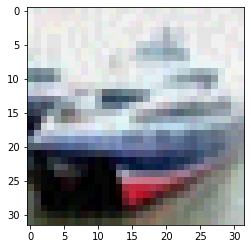

In [17]:
plt.imshow(image_adversarial[0])

In [18]:
get_classification_report(image_adversarial, k=3)

Predicted class: automobile, with proba: 1.000
Predicted class: ship, with proba: 0.000
Predicted class: truck, with proba: 0.000


# 2. Targetted

![](https://cv-tricks.com/wp-content/uploads/2018/05/target_fgsm.png)

Define the target class. You can print all cifar classes in the correct order to make the decision. 

In [19]:
target_class = 0
cifar_classes

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')

Define the epsilon. You can experiment with different epsilon sizes.


In [0]:
eps = 0.04

Define the attack. The code should look almost the same as the code for untargetted atack.

In [0]:
with tf.GradientTape() as g:
    g.watch(test_image)
    logits = model(test_image)
    one_hot_target = tf.one_hot([target_class], NUM_CLASSES)
    image_cross_entropy = cce(one_hot_target, logits)
    

grad = g.gradient(image_cross_entropy, test_image)
image_adversarial = test_image - eps * tf.sign(grad)
image_adversarial = tf.clip_by_value(image_adversarial, 0.0, 1.0)

## Plot the image after attack and check the network classification

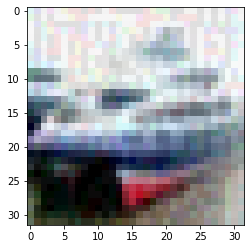

In [22]:
plt.imshow(image_adversarial[0])

In [23]:
get_classification_report(image_adversarial, k=3)

Predicted class: airplane, with proba: 0.987
Predicted class: automobile, with proba: 0.010
Predicted class: truck, with proba: 0.003


# 3. Targetted iterative

![](https://cv-tricks.com/wp-content/uploads/2018/05/iterative.png)

Define the target class. You can print all cifar classes in the correct order to make the decision. 

In [24]:
target_class = 0
cifar_classes

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')

Define the epsilon and iterations number.

During this attack you will apply the gradient multiple times, so that the epsilon value should be lower.

In [0]:
eps = 0.005
n_iters = 10

Define the attack. The code should look almost the same as the code for FGSM atacks. The difference is that you should apply the gradient *n_iters* times.

In [0]:
image_adversarial = test_image

for _ in range(n_iters):
    with tf.GradientTape() as g:
        g.watch(image_adversarial)
        logits = model(image_adversarial)
        one_hot_target = tf.one_hot([target_class], NUM_CLASSES)
        image_cross_entropy = cce(one_hot_target, logits)


    grad = g.gradient(image_cross_entropy, image_adversarial)
    image_adversarial = image_adversarial - eps * tf.sign(grad)
    image_adversarial = tf.clip_by_value(image_adversarial, 0.0, 1.0)

## Plot the image after attack and check the network classification

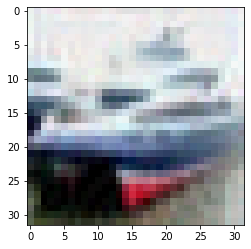

In [27]:
plt.imshow(image_adversarial[0])

In [28]:
get_classification_report(image_adversarial, k=3)

Predicted class: airplane, with proba: 1.000
Predicted class: ship, with proba: 0.000
Predicted class: truck, with proba: 0.000


# 4. Retrain with adversarial examples

We don't have good methods for defense against adversarial attacks.


One of the easiest and most brute-force way to defend against these attacks is to pretend to be the attacker, generate a number of adversarial examples against your own network, and then explicitly train the model to not be fooled by them. 

Define the function that takes the image and calculates the targeted iterative attack. This time the target class wont be defined by a random guess. Instead we will set it to the least likely class predicted by the network.

In [0]:
eps = 0.01
n_iters = 10


def iterative_least_likely_method(image):
    image_adversarial = tf.convert_to_tensor(image)

    for _ in range(n_iters):
        with tf.GradientTape() as g:
            g.watch(image_adversarial)
            logits = model(image_adversarial)
            least_likely_class = tf.argmin(logits, 1)
            one_hot_target = tf.one_hot(least_likely_class, NUM_CLASSES)
            image_cross_entropy = cce(one_hot_target, logits)

        grad = g.gradient(image_cross_entropy, image_adversarial)
        image_adversarial = image_adversarial - eps * tf.sign(grad)
        image_adversarial = tf.clip_by_value(image_adversarial, 0.0, 1.0)

    return image_adversarial

Define the function that apply *iterative_least_likely_method* to the given dataset, in batches.

In [0]:
def get_dataset_adversarials(X, batch_size):
    X_adv = []
    for i in range(0, X.shape[0], batch_size):
        X_batch = X[i:(i+batch_size)]
        X_batch_adv = iterative_least_likely_method(X_batch)
        X_adv.append(X_batch_adv.numpy())
        
    X_adv = np.concatenate(X_adv)
    return X_adv

Check the accuracy on test adversarial dataset

In [0]:
X_test_adv = get_dataset_adversarials(X_test, 1000)

In [32]:
model.evaluate(X_test_adv, y_test)

10000/10000 [==============================] - 1s 111us/sample - loss: 1.4682 - accuracy: 0.6322


[1.4681687894821167, 0.6322]

Create the adversarial dataset using predefined functions and train the model on it.

In [0]:
X_train_adv = get_dataset_adversarials(X_train, 1000)

In [34]:
model.fit(X_train_adv, y_train, epochs=1, batch_size=128,
          validation_data=(X_test, y_test))

Train on 50000 samples, validate on 10000 samples
50000/50000 [==============================] - 4s 77us/sample - loss: 0.5246 - accuracy: 0.8158 - val_loss: 0.8799 - val_accuracy: 0.7319


Check the accuracy on test adversarial dataset, after the adversarial training

In [35]:
model.evaluate(X_test_adv, y_test)

10000/10000 [==============================] - 1s 111us/sample - loss: 0.9340 - accuracy: 0.7032


[0.9340241143226623, 0.7032]

# Images sources

Images used in this notebook comes from the following web pages and papers:


1.   [Explaining and Harnessing Adversarial Examples](https://arxiv.org/pdf/1412.6572.pdf)
2.   [OpenAI blog - Attacking Machine Learning
with Adversarial Examples](https://openai.com/blog/adversarial-example-research/)
3.   [Breaking Deep Learning with Adversarial examples using Tensorflow](https://cv-tricks.com/how-to/breaking-deep-learning-with-adversarial-examples-using-tensorflow/)

